In [35]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader, TensorDataset
from backpack import backpack, extend
from backpack.extensions import DiagHessian

In [36]:
# Create base images (happy, sad, neutral faces)
def create_base_images():
    base_images = np.zeros((3, 16, 16))
    # Happy face (index 0)
    base_images[0, 4, 4] = base_images[0, 4, 11] = 1  # Eyes
    base_images[0, 10, 5:11] = 1  # Smile (curved upwards)
    base_images[0, 11, 4] = base_images[0, 11, 11] = 1  # Smile curve corners
    base_images[0, 12, 3] = base_images[0, 12, 12] = 1  # Smile curve corners
    
    # Sad face (index 1)
    base_images[1, 4, 4] = base_images[1, 4, 11] = 1  # Eyes
    base_images[1, 11, 5:11] = 1  # Frown (curved downwards)
    base_images[1, 10, 4] = base_images[1, 10, 11] = 1  # Smile curve corners
    base_images[1, 9, 3] = base_images[1, 9, 12] = 1  # Smile curve corners

    # Neutral face (index 2)
    base_images[2, 4, 4] = base_images[2, 4, 11] = 1  # Eyes
    base_images[2, 10, 4:12] = 1  # Straight line for mouth
    
    return base_images

# Generate noisy dataset
def generate_dataset(base_images, label=-1, num_samples=3000, noise_level=0.2):
    images = []
    labels = []
    in_label=label
    for i in range(num_samples):
        if in_label == -1:
            label = np.random.randint(0, 3)
        img = base_images[label] + noise_level * np.random.randn(16, 16)
        img = np.clip(img, 0, 1)  # Keep pixel values between 0 and 1
        images.append(img)
        labels.append(label)
    return torch.tensor(images, dtype=torch.float32).unsqueeze(1), torch.tensor(labels, dtype=torch.long)

# Define simple CNN model
class SimpleCNN(nn.Module):
    def __init__(self):
        super(SimpleCNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 8, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(8, 16, kernel_size=3, padding=1)
        self.fc1 = nn.Linear(16 * 16 * 16, 64)
        self.fc2 = nn.Linear(64, 3)  # 3 classes
    
    def forward(self, x):
        x = torch.relu(self.conv1(x))
        x = torch.relu(self.conv2(x))
        x = x.view(x.size(0), -1)  # Flatten
        x = torch.relu(self.fc1(x))
        x = self.fc2(x)
        return x
    
# Compute Hessian
def compute_hessian(model, criterion, data, target):
    model.zero_grad()
    output = model(data)
    loss = criterion(output, target)
    grad_params = torch.autograd.grad(loss, model.parameters(), create_graph=True)
    hessian = []
    for grad in grad_params:
        grad_vector = grad.view(-1)
        row = []
        for g in grad_vector:
            second_derivative = torch.autograd.grad(g, model.parameters(), retain_graph=True)
            row.append(torch.cat([sd.contiguous().view(-1) for sd in second_derivative]))
        hessian.append(torch.stack(row))
    return torch.cat(hessian, dim=0)

# Training function
def train(model, train_loader, criterion, optimizer, epochs=5):
    for epoch in range(epochs):
        for images, labels in train_loader:
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
        print(f'Epoch [{epoch+1}/{epochs}], Loss: {loss.item():.4f}')


In [37]:

# Main execution

base_images = create_base_images()
n_samples = 3000
images_h, labels_h = generate_dataset(base_images, label=0, num_samples=n_samples//3)
images_s, labels_s = generate_dataset(base_images, label=1, num_samples=n_samples//3)
images_n, labels_n = generate_dataset(base_images, label=2, num_samples=n_samples//3)
train_dataset_h = TensorDataset(images_h, labels_h)
train_dataset_s = TensorDataset(images_s, labels_s)
train_dataset_n = TensorDataset(images_n, labels_n)
train_dataset = train_dataset_h + train_dataset_s + train_dataset_n
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)

model = nn.Sequential(
    nn.Conv2d(1, 8, kernel_size=3, padding=1),
    nn.ReLU(),
    nn.Conv2d(8, 16, kernel_size=3, padding=1),
    nn.ReLU(),
    nn.Flatten(),                    # Flatten the 16x16x16 feature map
    nn.Linear(16 * 16 * 16, 64),
    nn.ReLU(),
    nn.Linear(64, 3)                 # 3 classes
)

model = extend(model)
criterion = nn.CrossEntropyLoss()
lossfunc = extend(criterion)
optimizer = optim.Adam(model.parameters(), lr=0.001)

train(model, train_loader, criterion, optimizer, epochs=5)

Epoch [1/5], Loss: 0.0010
Epoch [2/5], Loss: 0.0004
Epoch [3/5], Loss: 0.0001
Epoch [4/5], Loss: 0.0000
Epoch [5/5], Loss: 0.0000


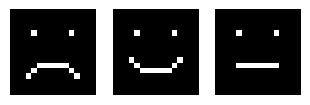

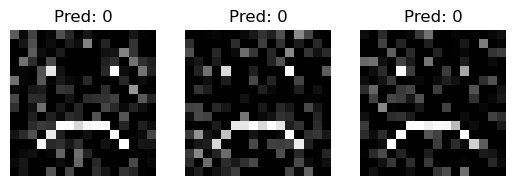

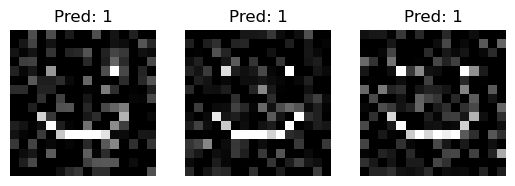

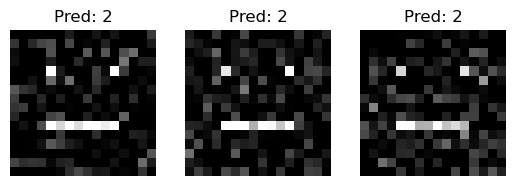

In [38]:

# Test model on some samples
test_samples_h, _ = generate_dataset(base_images, label=0, num_samples=3)
test_samples_s, _ = generate_dataset(base_images, label=1, num_samples=3)
test_samples_n, _ = generate_dataset(base_images, label=2, num_samples=3)
test_samples = torch.cat((test_samples_h, test_samples_s, test_samples_n), dim=0)

with torch.no_grad():
    predictions = model(test_samples).argmax(dim=1)

# Show some test images
for i in range(3):
    plt.subplot(1, 5, i+1)
    plt.imshow(base_images[i].squeeze(), cmap='gray')
    plt.axis('off')
plt.show()

# Show some test images
for i in range(3):
    plt.subplot(2, 3, i+1)
    plt.imshow(test_samples[i].squeeze(), cmap='gray')
    plt.title(f'Pred: {predictions[i].item()}')
    plt.axis('off')
plt.show()
for i in range(3):
    plt.subplot(2, 3, i+1)
    plt.imshow(test_samples[3+i].squeeze(), cmap='gray')
    plt.title(f'Pred: {predictions[3+i].item()}')
    plt.axis('off')
plt.show()
for i in range(3):
    plt.subplot(2, 3, i+1)
    plt.imshow(test_samples[6+i].squeeze(), cmap='gray')
    plt.title(f'Pred: {predictions[6+i].item()}')
    plt.axis('off')
plt.show()


In [39]:
for param in model.parameters():
    print(type(param.data), param.size())

<class 'torch.Tensor'> torch.Size([8, 1, 3, 3])
<class 'torch.Tensor'> torch.Size([8])
<class 'torch.Tensor'> torch.Size([16, 8, 3, 3])
<class 'torch.Tensor'> torch.Size([16])
<class 'torch.Tensor'> torch.Size([64, 4096])
<class 'torch.Tensor'> torch.Size([64])
<class 'torch.Tensor'> torch.Size([3, 64])
<class 'torch.Tensor'> torch.Size([3])


In [40]:
from torch import cat

model.eval()

train_images=torch.cat([images_h,images_s,images_n])
train_labels=torch.cat([labels_h,labels_s,labels_n])
half_images = torch.cat([images_h,images_n,images_s[:len(images_s)//2]])
half_labels = torch.cat([labels_h,labels_n,labels_s[:len(labels_s)//2]])
unp_images = torch.cat([images_h,images_n])
unp_labels = torch.cat([labels_h,labels_n])

#Compute the Hessian with poisoned dataset
loss = lossfunc(model(train_images), train_labels)

with backpack(DiagHessian()):
    loss.backward(retain_graph=True)
hessian = [p.diag_h.clone() for p in model.parameters()]

for p in model.parameters():
    if hasattr(p, 'diag_h'):
        del p.diag_h


#Compute the Hessian with half poisoned dataset
loss_half = lossfunc(model(half_images), half_labels)

with backpack(DiagHessian()):
    loss_half.backward()
hessian_half = [p.diag_h.clone() for p in model.parameters()]

for p in model.parameters():
    if hasattr(p, 'diag_h'):
        del p.diag_h

#Compute the Hessian with unpoisoned dataset
loss_unp = lossfunc(model(unp_images), unp_labels)

with backpack(DiagHessian()):
    loss_unp.backward()
hessian_unp = [p.diag_h.clone() for p in model.parameters()]


In [41]:
def compute_der(tensor1, tensor2):
    #Compute first derivative integrals of FI
    ratio = tensor1/tensor2
    return torch.log(ratio)+ 1/2 * (1-torch.pow(ratio,2))

information = [torch.empty_like(p) for p in hessian]
for i,_ in enumerate(information):
    #Compute second derivative integrals of FI
    der1 = compute_der(hessian[i], hessian_half[i])
    der2 = compute_der(hessian_half[i], hessian_unp[i])
    information[i]= der2-der1

#Compute relative differences(just for testing and studying)
delta = [torch.empty_like(p) for p in hessian]
for i,_ in enumerate(delta):
    delta[i] = (hessian[i]-hessian_unp[i])/hessian[i]

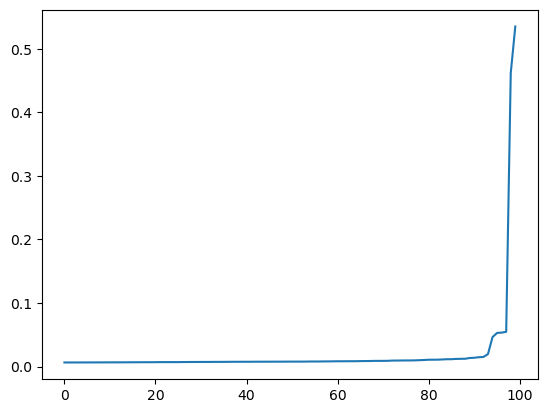

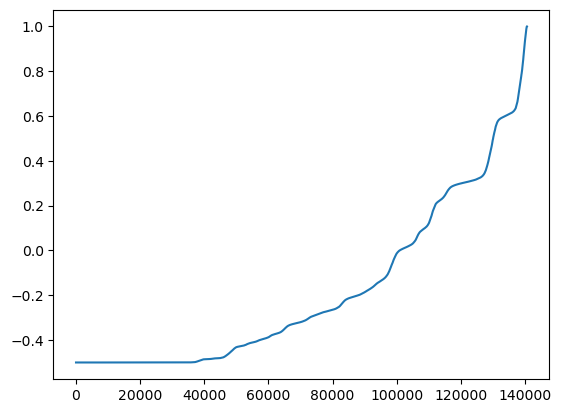

In [42]:
import matplotlib.pyplot as plt

infocat = cat([p.flatten() for p in information])
s_infocat = np.sort(torch.nan_to_num(infocat))
plt.plot(s_infocat[-100:])
plt.show()

deltacat = cat([p.flatten() for p in delta])
s_deltacat = np.sort(deltacat)
plt.plot(s_deltacat)
plt.show()

In [43]:
def evaluate_accuracy(model, dataloader):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for inputs, targets in dataloader:
            outputs = model(inputs)
            _, predicted = torch.max(outputs.data, 1)
            total += targets.size(0)
            correct += (predicted == targets).sum().item()
    return correct / total

In [44]:
import copy

acc_h = evaluate_accuracy(model, DataLoader(train_dataset_h, batch_size=32, shuffle=False))
acc_s = evaluate_accuracy(model, DataLoader(train_dataset_s, batch_size=32, shuffle=False))
acc_n = evaluate_accuracy(model, DataLoader(train_dataset_n, batch_size=32, shuffle=False))

print(f'Accuracy original model')
print(f'Accuracy on happy faces: {acc_h:.2f}')
print(f'Accuracy on sad faces: {acc_s:.2f}')
print(f'Accuracy on neutral faces: {acc_n:.2f}')
print(f'\n\n')

model_clone = copy.deepcopy(model)
noise_std = 10
ts=0.002

#Statistical analysis of the impact of the noise on the accuracy
N=100
acc_h_unp_list = np.zeros(N)
acc_s_unp_list = np.zeros(N)
acc_n_unp_list = np.zeros(N)

for j in range(N):

    if j%10==0:
        print(f'Iteration {j}')

    for i,p in enumerate(information):
        information[i]=torch.nan_to_num(information[i])
        #Set a minimum value for the information, below don't add noise
        information[i]=torch.clamp(information[i],min=ts)

    with torch.no_grad():
        for i,param in enumerate(model_clone.parameters()):
            #Add noise weighting on the information carried by each parameter
            noise = torch.randn(param.size()) * noise_std * information[i]
            param.add_(noise)
    acc_h_unp_list[j] = evaluate_accuracy(model_clone, DataLoader(train_dataset_h, batch_size=32, shuffle=False))
    acc_s_unp_list[j] = evaluate_accuracy(model_clone, DataLoader(train_dataset_s, batch_size=32, shuffle=False))
    acc_n_unp_list[j] = evaluate_accuracy(model_clone, DataLoader(train_dataset_n, batch_size=32, shuffle=False))

acc_h_unp = np.average(acc_h_unp_list)
acc_h_unp_var = np.var(acc_h_unp_list)
acc_s_unp = np.average(acc_s_unp_list)
acc_s_unp_var = np.var(acc_s_unp_list)
acc_n_unp = np.average(acc_n_unp_list)
acc_n_unp_var = np.var(acc_n_unp_list)

print(f'Accuracy modified model')
print(f'Accuracy on happy faces: {acc_h_unp:.2f}')
print(f'Variance on happy faces: {acc_h_unp_var:.2f}')
print(f'Accuracy on sad faces: {acc_s_unp:.2f}')
print(f'Variance on sad faces: {acc_s_unp_var:.2f}')
print(f'Accuracy on neutral faces: {acc_n_unp:.2f}')
print(f'Variance on neutral faces: {acc_n_unp_var:.2f}')


Accuracy original model
Accuracy on happy faces: 1.00
Accuracy on sad faces: 1.00
Accuracy on neutral faces: 1.00



Iteration 0
Iteration 10
Iteration 20
Iteration 30
Iteration 40
Iteration 50
Iteration 60
Iteration 70
Iteration 80
Iteration 90
Accuracy modified model
Accuracy on happy faces: 1.00
Variance on happy faces: 0.00
Accuracy on sad faces: 0.42
Variance on sad faces: 0.24
Accuracy on neutral faces: 0.33
Variance on neutral faces: 0.18
